# Python for Interactive Supernova-Cosmology Light-Curve Analysis: __PISCoLA__

## Test notebook

by Tomás Müller (University of Southampton)

___
It is recommended to run the lines one by one to get familiar with each of the functions being used (also check the docstrings!). However, I will breifly describe part of the routine below.
## Single epoch test

* The first thing to do is to set the SED template epoch/phase (respect to B-band peak) which will be used for the corrections.
* The normalization of the data helps to move all the zero-points to the same magnitude scale.
* The light curves can the be fit with Gaussian Process. A mask can be applied to the data, but the light curves need to be fit before doing so. For example, the mask can help removing data at very late time with large gaps (large gaps can decrease the quality of the GP fits!)
* It is always good to plot the different steps to make sure you understand what is happening.
* You need to choose the epochs/phases which you want to include for the light curves corrections (the more epchos, the longer it is going to take!)
* Then you can proceed to mangle the SED (template matching), one epoch at a time.
* After this, the extinction correction and K-corrections can be applied.

The example below is only for one epoch.

In [1]:
import piscola as pisco
import numpy as np

name = sn2001cz, z = 0.01538, ra = 191.875708, dec = -39.580028000000006


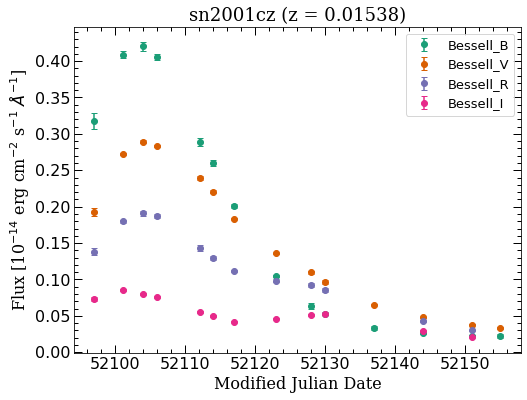

Pivot band: Bessell_B
Initial B-band peak estimation: 52103.36599997814


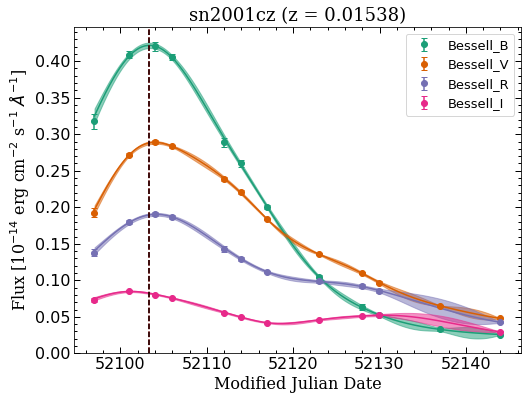

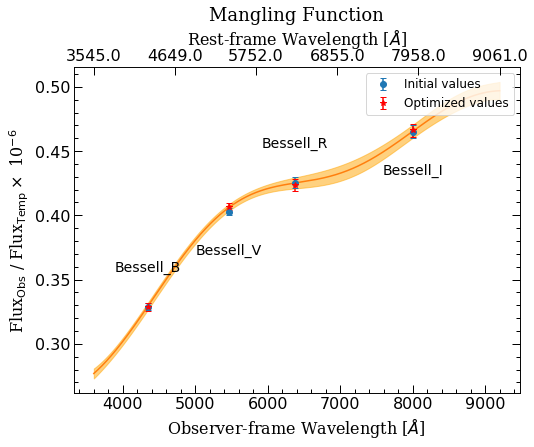

Mangling results, i.e., difference between mangled SED and "observed" magnitudes, at phase 0:
Bessell_B: 1.3739764881393057e-10 [mags]
Bessell_V: -1.0417274154406186e-08 [mags]
Bessell_R: -1.5852776868996443e-08 [mags]
Bessell_I: -1.3362466688704444e-09 [mags]


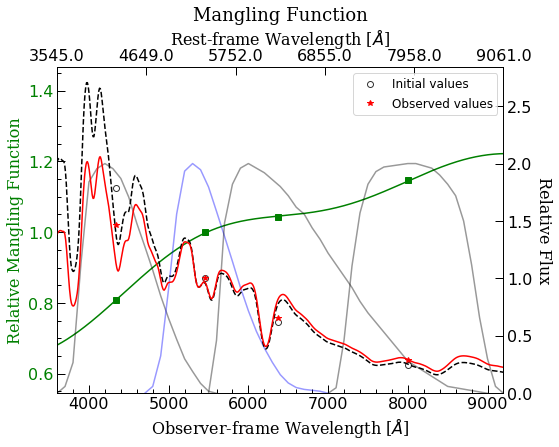

Mangling results, i.e., difference between mangled SED and "observed" magnitudes, at phase 0:
Bessell_B: 1.3739764881393057e-10 [mags]
Bessell_V: -1.0417274154406186e-08 [mags]
Bessell_R: -1.5852776868996443e-08 [mags]
Bessell_I: -1.3362466688704444e-09 [mags]


In [2]:
sn = pisco.sn_file('sn2001cz')
print(sn)

########################
sn.phase=0
sn.set_sed_epoch()
sn.delete_bands('g_swope')

sn.normalize_data()
sn.plot_data(plot_type='flux')

sn.fit_lcs(kernel='matern52')
sn.mask_data(mask_snr=False, mask_phase=True, min_phase=-20, max_phase=40)
sn.fit_lcs(kernel='matern52')

print('Pivot band:', sn.pivot_band)
print('Initial B-band peak estimation:', sn.tmax)
sn.plot_fits()

########################

phases = np.arange(-10, 21, 0.5)
sn.set_interp_data(restframe_phases=phases)

########################

sn.mangle_sed(kernel='squaredexp', method='gp')
sn.plot_mangling_function()
sn.plot_mangling_function(mangle_only=False)

sn.correct_extinction()
sn.kcorrection()

___
## Multi-epoch test

`correct_light_curve` applies most of the steps described above and loops over the given epochs. Then, `check_B_peak` checks whether the inital estimation of the B-band peak matches the final estimation (after all the corrections), and if not, repeat the correction process with the new estimation of the peak until the chosen criteria (difference between inital and final peak) is satisfied.

Once this is done, the light-curves parameters can be estimated.

Starting light curve correction for sn2001cz...


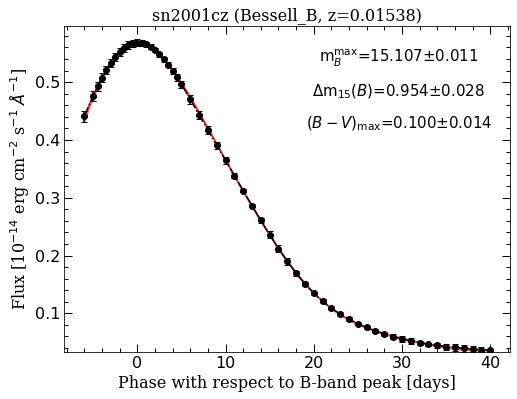

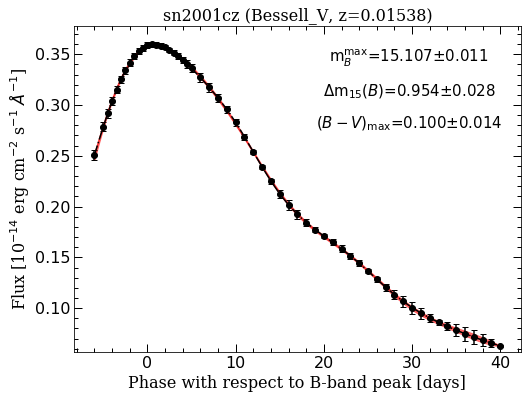

CPU times: user 4min 44s, sys: 5min 13s, total: 9min 57s
Wall time: 1min 24s


In [3]:
%%time
import piscola as pisco
import numpy as np

sn = pisco.sn_file('sn2001cz')

sn.set_sed_epoch()
sn.normalize_data()
sn.delete_bands('g_swope')

sn.fit_lcs(kernel='matern52')
sn.mask_data(mask_snr=False, mask_phase=True, min_phase=-20, max_phase=40)
sn.fit_lcs(kernel='matern52')

phases = np.r_[np.arange(-20, -5), np.arange(-5, 5, 0.5), np.arange(5, 41)]
sn.set_interp_data(restframe_phases=phases)

sn.correct_light_curve(kernel='matern52')
sn.check_B_peak(kernel='matern52')

sn.calc_lc_parameters()
sn.display_results('Bessell_B')
try:
    sn.display_results('Bessell_V')
except:
    pass

___
## Multiple SNe in parallel

Here we create a function that does the complete routine to fit a SN.

In [5]:
%load_ext line_profiler
from multiprocessing import Pool
import piscola as pisco
import numpy as np

def run_piscola(sn_name):
    try:
        sn = pisco.sn_file(sn_name)
        print(f'processing {sn_name}...')
        
        sn.set_sed_epoch()
        sn.normalize_data()

        # Sifto
        sn.delete_bands(['u_2.5m', 'z_2.5m'])  # SDSS
        sn.delete_bands(['g_swope'])
        
        kernel='matern52'
        sn.fit_lcs(kernel=kernel)
        sn.mask_data(mask_snr=False, mask_phase=True, min_phase=-20, max_phase=40)
        sn.fit_lcs(kernel=kernel)

        phases = np.r_[np.arange(-20, -5), np.arange(-5, 5, 0.5), np.arange(5, 41)]
        sn.set_interp_data(restframe_phases=phases)

        kernel = 'squaredexp'
        method='gp'
        scaling = 0.86
        sn.correct_light_curve(scaling=scaling, kernel=kernel, method=method)
        sn.check_B_peak(scaling=scaling, kernel=kernel, method=method)
        sn.calc_lc_parameters()
        sn.save(sn_name, path='obj/')  # uncomment this line to save the results in dictionaries (pickle objects)
        print(f'{sn_name} successful!')
        return sn.name
    except Exception as e: 
        print(f'{sn_name} failed:', e)

Below we call the routine we defined above and use multiprocessing to paralelyse it.

In [6]:
import glob

lowz = [file.split('/')[1][:-4] for file in glob.glob('data/*') if 'sn' in file]
sdss = [file.split('/')[1][:-4] for file in glob.glob('data/*') if 'SDSS' in file]
snls03 = [file.split('/')[1][:-4] for file in glob.glob('data/*') if file.split('/')[1].startswith('03')]
snls04 = [file.split('/')[1][:-4] for file in glob.glob('data/*') if file.split('/')[1].startswith('04')]
snls05 = [file.split('/')[1][:-4] for file in glob.glob('data/*') if file.split('/')[1].startswith('05')]
snls06 = [file.split('/')[1][:-4] for file in glob.glob('data/*') if file.split('/')[1].startswith('06')]
snls = [file.split('/')[1][:-4] for file in glob.glob('data/*') if file.split('/')[1].startswith('0')]
hst = [file.split('/')[1][:-4] for file in glob.glob('data/*') if (file.split('/')[1][:-4] not in lowz) 
       & (file.split('/')[1][:-4] not in sdss) & (file.split('/')[1][:-4] not in snls)]

samples_dict = {'lowz':lowz, 'sdss':sdss, 'snls03':snls03, 'snls04':snls04, 'snls05':snls05, 'snls06':snls06, 'hst':hst}

In [15]:
sample = 'snls04'
%time successful_sne = Pool().map(run_piscola, (sn_name for sn_name in samples_dict[sample]))

___
We can also save the necessary parameters into a file to use them later on.

In [6]:
import pandas as pd

params = pd.DataFrame({'sn':[], 'z':[], 'tmax':[], 'mb':[], 'dmb':[],'dm15':[], 'dm15err':[], 'color':[], 'dcolor':[]})

for sn_name in successful_sne: 
    
    if sn_name is not None:
        sn = pisco.load_sn(sn_name, path='obj/')
        tmax = sn.tmax
        mb = sn.lc_parameters['mb']
        dmb = sn.lc_parameters['dmb']
        dm15 = sn.lc_parameters['dm15']
        dm15err = sn.lc_parameters['dm15err']
        color = sn.lc_parameters['color']
        dcolor = sn.lc_parameters['dcolor']

        columns = ['sn', 'z', 'tmax', 'mb', 'dmb', 'dm15', 'dm15err', 'color', 'dcolor']
        values = [sn.name, sn.z, tmax, mb, dmb, dm15, dm15err, color, dcolor]

        row = pd.DataFrame(data=[values], columns=columns)
        params = params[['sn', 'z', 'tmax', 'mb', 'dmb', 'dm15', 'dm15err', 'color', 'dcolor']].append(row)

params.to_csv(f'{sample}_sample.csv', index=False)
print('ready')

ready


___
### Join samples

In [19]:
import pandas as pd

# Join all samples in one
df_list = list()

for sample_name in samples_dict.keys():
    try:
        df = pd.read_csv(f'{sample_name}_sample.csv')
        df_list.append(df)
    except:
        pass
    
df_samples = pd.concat(df_list)
df_samples.to_csv('sifto_sample.csv', index=False)